In [1]:
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy.spatial as es
from matplotlib import pyplot
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np
from scipy import stats
import os
import glob

For starting I need to identify the growing season to specify dates for the Landsat 7 data

In [2]:
crop_data = pd.read_excel('thermal_data_2021/twitchell_ET_2011.xls')
crop_data.head()

,Year,Month,Day,Julian,Unnamed: 4,crop.type,Tmx,Tmn,VPD,NDVI,EVI,ET
0,2011,1,1,1,731,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
1,2011,1,2,2,732,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
2,2011,1,3,3,733,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
3,2011,1,4,4,734,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
4,2011,1,5,5,735,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567


<AxesSubplot:xlabel='Julian'>

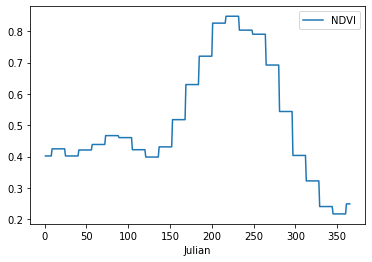

In [3]:
crop_data.plot('Julian', 'NDVI')

After plotting the graph I will define the growing season to where NDVI is above 0.5

Then I will quickly check the minimum and maximum 'Month' values (first and last) and this will give me a guide for the dates to specify. In this case it will be between June and October

In [4]:
growing_season = crop_data[crop_data['NDVI'] > 0.5]
growing_season['Month'].describe()

count    144.000000
mean       7.909722
std        1.368544
min        6.000000
25%        7.000000
50%        8.000000
75%        9.000000
max       10.000000
Name: Month, dtype: float64

After downloading the data from https://earthexplorer.usgs.gov/ using the specified dates, its time to load and sort the data. I only need the thermal 2 band from each scene (In this case band 6-2). I will label them using the date.

In [6]:
DN_tifs = glob.glob('thermal_data_2021/DNs/**/*B6_VCID_2.TIF', recursive=True)
DN_tifs.sort()

dates = list(os.walk('thermal_data_2021/DNs/'))[0]
dates = dates[1]
dates.sort()

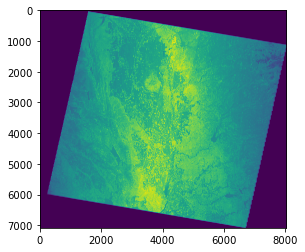

In [95]:
#visualise one raster to make sure everything looks correct. Throughout this exercise I will visualise the image from 8th July 2011

with rio.open('thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B6_VCID_2.TIF') as src:
    DN_layer = src.read().transpose(1,2,0)
pyplot.imshow(DN_layer)

In [8]:
# define the function to calculate Top of Atmosphere (TOA) radiance

Lmax = 12.650
Lmin = 3.200
Qcalmax = 255
Qcalmin = 1

def TOA_radiance(DN):
    return (Lmax-Lmin) / (Qcalmax-Qcalmin) * (DN-Qcalmin) + Lmin


In [113]:
# loop through images, calculate TOA Radiance and save to disc

for tif, date in zip(DN_tifs, dates):
    with rio.open(tif) as src:
        data = src.read().astype(float).transpose(1,2,0)
        #data[data < 1] = np.nan
        np.save(f'thermal_data_2021/DNs/{date}_DN_array', data)
       

In [114]:
DN_arrays = glob.glob('thermal_data_2021/DNs/*.npy')
DN_arrays.sort()

for DN, date in zip(DN_arrays, dates):
    array = np.load(f'thermal_data_2021/DNs/{date}_DN_array.npy')
    array = TOA_radiance(array)
    np.save(f'thermal_data_2021/TOA_Radiance/{date}_TOA_radiance', array)

(array([2.5599631e+07, 1.9800000e+02, 1.9400000e+02, 2.4619000e+04,
        1.2046400e+05, 5.0989700e+05, 9.9131460e+06, 1.0075988e+07,
        8.4845340e+06, 2.1388400e+06]),
 array([ 3.16279528,  4.11151575,  5.06023622,  6.00895669,  6.95767717,
         7.90639764,  8.85511811,  9.80383858, 10.75255906, 11.70127953,
        12.65      ]),
 <BarContainer object of 10 artists>)

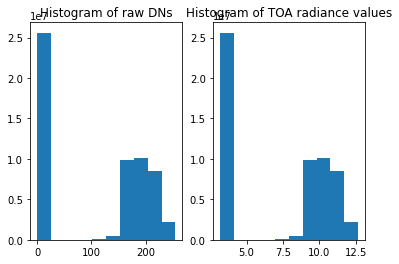

In [115]:
# compare DN to radiance values

#load the new radiance raster layer

RAD_layer = np.load('thermal_data_2021/TOA_Radiance/20110708_TOA_radiance.npy')

# plot histograms
fig, (ax1, ax2) = pyplot.subplots(1, 2)
ax1.set_title('Histogram of raw DNs')
ax1.hist(DN_layer.flatten())
ax2.set_title('Histogram of TOA radiance values')
ax2.hist(RAD_layer.flatten())



In [116]:
# define function to calculate Top of Atmosphere (TOA) brightness values

K1 = 666.09
K2 = 1282.71

def TOA_brightness(radiance):
    return (K2/(np.log(K1/radiance+1)))-272.15



(array([2.1780000e+03, 2.1400000e+02, 0.0000000e+00, 2.0500000e+02,
        3.3275000e+04, 1.2675400e+05, 1.0891760e+06, 1.1493696e+07,
        1.0251953e+07, 3.3870060e+07]),
 array([-34.93207099, -26.85933519, -18.78659939, -10.71386358,
         -2.64112778,   5.43160802,  13.50434383,  21.57707963,
         29.64981543,  37.72255123,  45.79528704]),
 <BarContainer object of 10 artists>)

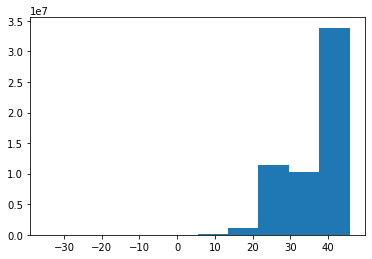

In [72]:
pyplot.hist(TOA_brightness(RAD_layer).flatten())

In [117]:
# loop through images, calculate TOA Brightness and save to disc
RAD_arrays = glob.glob('thermal_data_2021/TOA_Radiance/*.npy')
RAD_arrays.sort()

for RAD, date in zip(RAD_arrays, dates):
    array = np.load(f'thermal_data_2021/TOA_Radiance/{date}_TOA_radiance.npy')
    array = TOA_brightness(array)
    np.save(f'thermal_data_2021/TOA_Brightness/{date}_TOA_brightness', array)

In [118]:
BRI_layer = np.load('thermal_data_2021/TOA_Brightness/20110708_TOA_brightness.npy')
     

(array([2.5599554e+07, 1.4300000e+02, 1.7200000e+02, 1.7600000e+02,
        2.8831000e+04, 1.2585300e+05, 1.3041630e+06, 1.3382501e+07,
        1.1521446e+07, 4.9046720e+06]),
 array([-32.6018183 , -24.34862802, -16.09543775,  -7.84224748,
          0.4109428 ,   8.66413307,  16.91732335,  25.17051362,
         33.4237039 ,  41.67689417,  49.93008445]),
 <BarContainer object of 10 artists>)

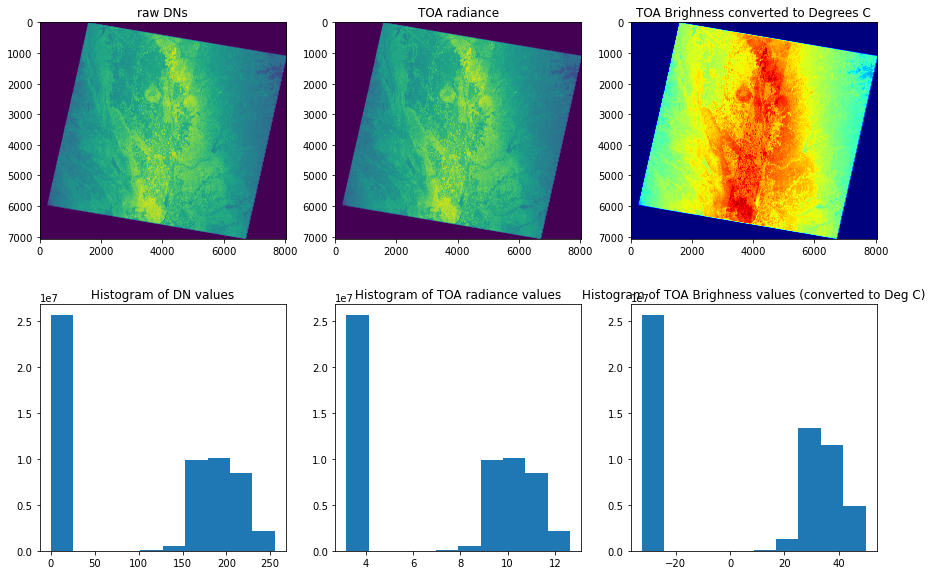

In [119]:
#using a single date for comparison (8 July 2011)

fig, axs = pyplot.subplots(2, 3, figsize=(15,10))
axs[0,0].set_title('raw DNs')
axs[0,0].imshow(DN_layer)
axs[0,1].set_title('TOA radiance')
axs[0,1].imshow(RAD_layer)
axs[0,2].set_title('TOA Brighness converted to Degrees C')
axs[0,2].imshow(BRI_layer, cmap='jet')
axs[1,0].set_title('Histogram of DN values')
axs[1,0].hist(DN_layer.flatten())
axs[1,1].set_title('Histogram of TOA radiance values')
axs[1,1].hist(RAD_layer.flatten())
axs[1,2].set_title('Histogram of TOA Brighness values (converted to Deg C)')
axs[1,2].hist(BRI_layer.flatten())


In [120]:
#compare TOA Radiance and TOA Brightness with sample tifs to ensure correct calculations

#open sample tiffs
with rio.open('thermal_data_2021/LS TOA/tifs/LS20110708TOA.tif') as src:
    sample_radiance = src.read().transpose(1,2,0)

with rio.open('thermal_data_2021/LS Brighntess T/tifs/LS20110708degC.tif') as src:
    sample_brightness = src.read().transpose(1,2,0)



(array([2.5586065e+07, 1.9100000e+02, 1.9200000e+02, 2.4652000e+04,
        1.2090900e+05, 5.1096000e+05, 9.9211780e+06, 1.0076991e+07,
        8.4859990e+06, 2.1403740e+06]),
 array([ 3.1627953,  4.1115155,  5.060236 ,  6.0089564,  6.957677 ,
         7.9063973,  8.855118 ,  9.803839 , 10.752559 , 11.70128  ,
        12.65     ], dtype=float32),
 <BarContainer object of 10 artists>)

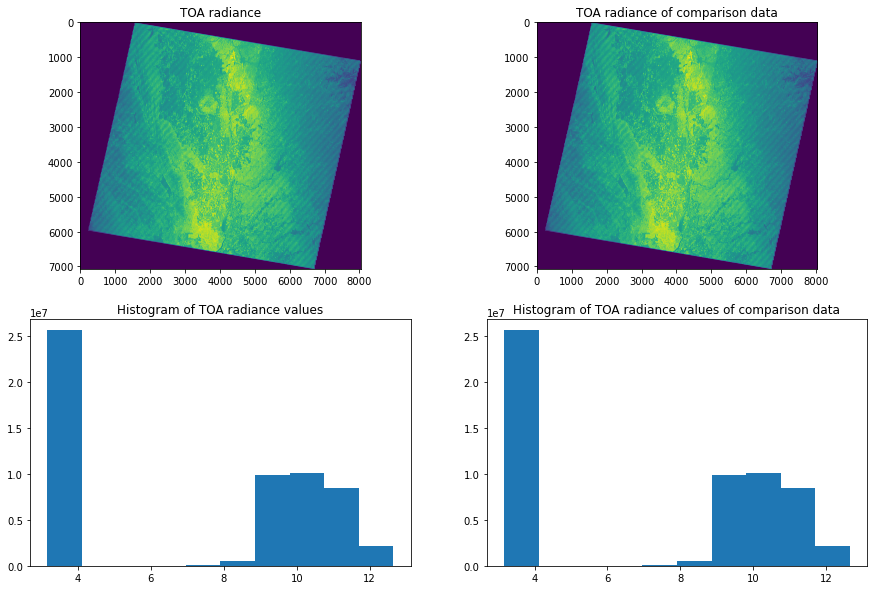

In [121]:
# render raster and plot histograms of my and sample Radiance values

fig, axs = pyplot.subplots(2, 2, figsize=(15,10))
axs[0,0].set_title('TOA radiance')
axs[0,0].imshow(RAD_layer)
axs[1,0].set_title('Histogram of TOA radiance values')
axs[1,0].hist(RAD_layer.flatten())
axs[0,1].set_title('TOA radiance of comparison data')
axs[0,1].imshow(sample_radiance)
axs[1,1].set_title('Histogram of TOA radiance values of comparison data')
axs[1,1].hist(sample_radiance.flatten())

(array([2.5585983e+07, 1.6300000e+02, 1.4600000e+02, 1.7300000e+02,
        2.8782000e+04, 1.2640000e+05, 1.3070760e+06, 1.3389492e+07,
        1.1522008e+07, 4.9072880e+06]),
 array([-33.60182  , -25.34863  , -17.09544  ,  -8.84225  ,  -0.5890595,
          7.664131 ,  15.917322 ,  24.170513 ,  32.423702 ,  40.676895 ,
         48.930084 ], dtype=float32),
 <BarContainer object of 10 artists>)

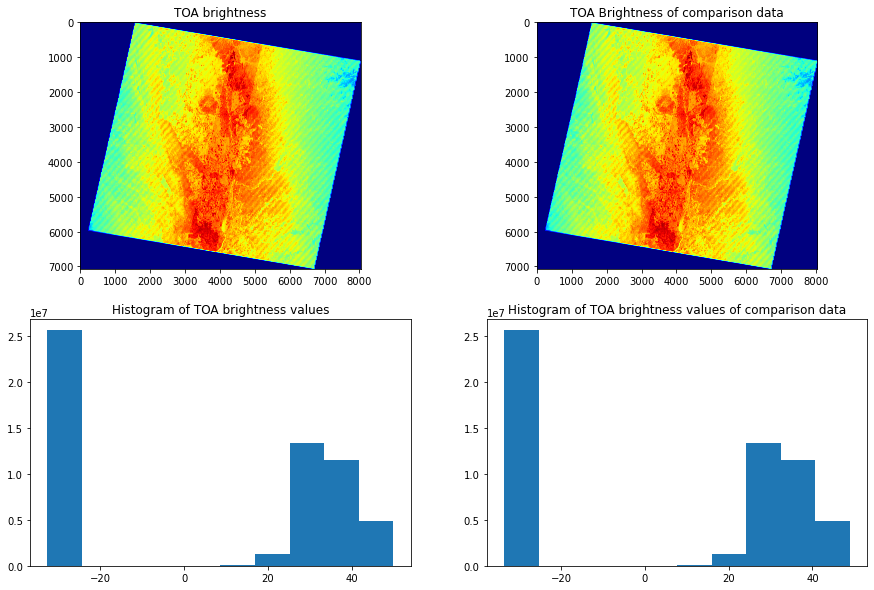

In [122]:
# render raster and plot histograms of my and sample Brightness values

fig, axs = pyplot.subplots(2, 2, figsize=(15,10))
axs[0,0].set_title('TOA brightness')
axs[0,0].imshow(BRI_layer, cmap='jet')
axs[1,0].set_title('Histogram of TOA brightness values')
axs[1,0].hist(BRI_layer.flatten())
axs[0,1].set_title('TOA Brightness of comparison data')
axs[0,1].imshow(sample_brightness, cmap='jet')
axs[1,1].set_title('Histogram of TOA brightness values of comparison data')
axs[1,1].hist(sample_brightness.flatten())

In [192]:
# # save brightness raster 
# with rio.open('thermal_data_2021/CDL_2014_clip_20200309111140_2143852610/CDL_2014_clip_20200309111140_2143852610.tif') as src:
#     with rio.open("thermal_data_2021/TOA_Brightness/20110708_brighntess.tif", "w", **out_meta) as dst:
#         dst.write(BRI_layer.transpose(2,0,1).astype(float))

In [185]:
# open the cropscape raster for comparison and get the extent (bounds)
with rio.open('thermal_data_2021/CDL_2014_clip_20200309111140_2143852610/CDL_2014_clip_20200309111140_2143852610.tif') as src:
    cropscape = src.read().transpose(1,2,0)
    bounds = src.bounds

# convert bounds to bounding box polygon 
bbox = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]}) 

In [186]:
#to get the false colour composite for visualisation
ir_tif = 'thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B4.TIF'
red_tif = 'thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B3.TIF'
green_tif = 'thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B2.TIF'
band_paths = [ir_tif, red_tif, green_tif]
# crop bands to cropscape extent
croped_band_paths = es.crop_all(band_paths,'thermal_data_2021/DNs/20110708/', bbox, overwrite=True)



In [187]:
false_colour, raster_prof = es.stack(croped_band_paths, out_path='thermal_data_2021/DNs/20110708/False_colour.tif')
false_colour = false_colour.transpose(1,2,0)

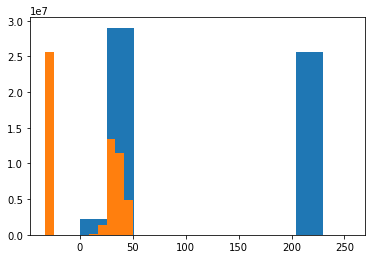

In [193]:
# with rio.open('thermal_data_2021/TOA_Brightness/20110708_brighntess.tif') as src:
#     cropped_brightness, meta = es.crop_image(src, bbox) 
#     cropped_brightness = cropped_brightness.transpose(1,2,0)
#     pyplot.hist(src.read().transpose(1,2,0).flatten())
#     pyplot.hist(BRI_layer.flatten())

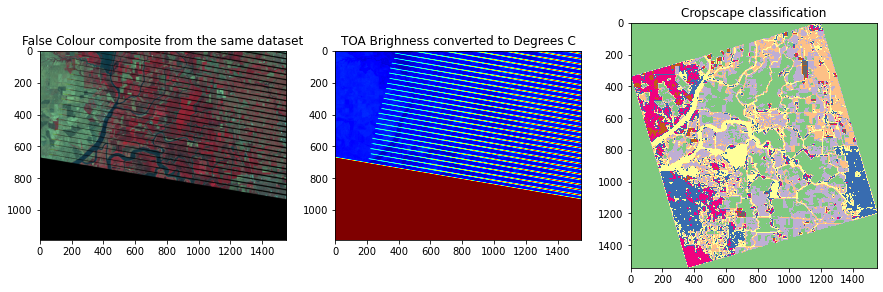

In [168]:

fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, figsize=(15,15))
ax1.set_title('False Colour composite from the same dataset')
ax1.imshow(false_colour)
ax2.set_title('TOA Brighness converted to Degrees C')
ax2.imshow(cropped_brightness, cmap='jet')
ax3.set_title('Cropscape classification')
ax3.imshow(cropscape, cmap='Accent')